In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import sys, os
from gvxrPython3 import gvxr
from gvxrPython3.JSON2gVXRDataReader import *
from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.plugins.astra import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.processors import TransmissionAbsorptionConverter, Padder
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import LeastSquares

def create_cylinder_with_spheres(simulation_name='cylinder', cylinder_radius = 100, plane = 'xy'):
    
    gvxr.removePolygonMeshesFromSceneGraph()
    sphere_radius =  cylinder_radius/10
    gvxr.makeCylinder(simulation_name, 100, sphere_radius*2, cylinder_radius, "um")

    sphere_spacing = 2 * sphere_radius + (sphere_radius/2)

    n_steps = int((cylinder_radius - sphere_radius) // sphere_spacing)


    i_values = np.arange(-n_steps, n_steps + 1) * sphere_spacing
    j_values = np.arange(-n_steps, n_steps + 1) * sphere_spacing

    
    positions = [
        (i, j)
        for i in i_values
        for j in j_values
        if np.sqrt(i**2 + j**2) <= cylinder_radius - sphere_radius
    ]

    if plane == 'xy': # I am using CIL definitions
        translations = [(i, j, 0) for i, j in positions]
        gvxr.rotateNode(simulation_name, 90, 1, 0, 0)
        gvxr.applyCurrentLocalTransformation(simulation_name)
    elif plane == 'xz': # I am using CIL definitions
        translations = [(0, i, j) for i, j in positions]
        gvxr.rotateNode(simulation_name, 90, 1, 0, 0)
        gvxr.rotateNode(simulation_name, 90, 0, 0, 1)
        gvxr.applyCurrentLocalTransformation(simulation_name)
    elif plane == 'yz': # I am using CIL definitions
        translations = [(i, 0, j) for i, j in positions]
    else:
        raise ValueError(f"Unsupported plane: {plane}")

                
    for N, (x, y, z) in enumerate(translations):
        sphere_name = f"sphere_{N}"
        # print(sphere_name)
        gvxr.makeSphere(sphere_name, 50, 50, sphere_radius, "um")
        gvxr.translateNode(sphere_name, x, y, z, "um")
        gvxr.applyCurrentLocalTransformation(sphere_name)
        gvxr.addMesh(simulation_name, sphere_name)

    gvxr.addPolygonMeshAsInnerSurface(simulation_name)
    gvxr.setCompound(simulation_name, "SiO2")
    gvxr.setDensity(simulation_name, 2.2,"g.cm-3")

c:\Users\bgb37495\AppData\Local\miniconda3\envs\lamino\Lib\site-packages\dxchange\__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


This notebook discusses the pros and cons of using the laminography geometry to image flat samples in 3D. For this example we will use the gVXR (GPU virtual x-ray) package which can be used to create realistic x-ray simulations. We use a gVXR digital twin of the DLS Dual Imaging and Diffraction (DIAD) beamline which can be accessed from https://github.com/TomographicImaging/DIAD2gVXR

In [2]:
# point to the digital twin code
sys.path.insert(0, os.path.abspath('../DIAD2gVXR/code'))
from DiadModel import DiadModel

# create a digital twin simulation and initialise with some experimental parameters
diad_model = DiadModel()
pixels_x = 1000
pixels_y = 1000
diad_model.detector_cols = pixels_x
diad_model.detector_rows = pixels_y
diad_model.initSimulationEnegine()
energy_in_keV = 25
exposure_in_sec = 0.003
diad_model.initExperimentalParameters(1, "m", energy_in_keV, exposure_in_sec)


Pink beam data files not found. You cannot use pink beam
Energy response data files not found. You'll use the analytical model


We create a simulation of a silica cylinder containing spheres, to start we will simulate the cylinder on the xz plane, i.e. orthogonal to the beam travelling along y and compute a single xray image.

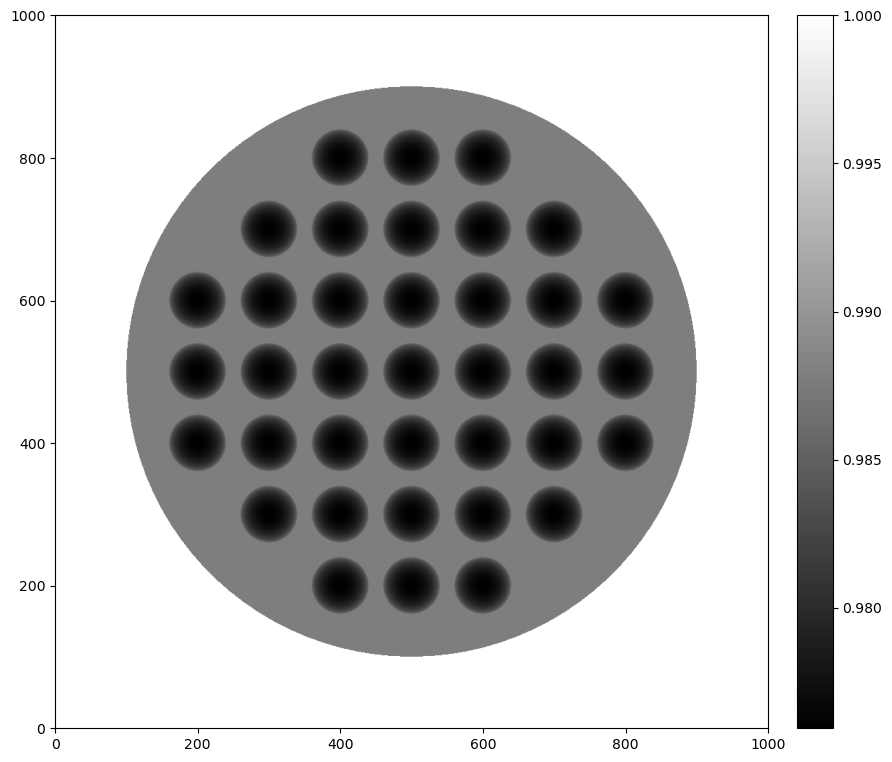

In [3]:
# Create the simulation
simulation_name = "cylinder"
create_cylinder_with_spheres(simulation_name=simulation_name, cylinder_radius=200, plane='xz')
# Compute an X-ray image
gvxr.displayScene()
xray_image = np.array(gvxr.computeXRayImage(), dtype=np.single)/ gvxr.getTotalEnergyWithDetectorResponse()
show2D(xray_image)

Next we simulate a full scan, starting with the normal tomography geometry so the sample is rotated around the z axis. We rotate the sample and generate projections measured at angles 0 to 360 degrees.

In [4]:
# specify number of projections
start = 0
stop = 360
step = 1
angle_set = np.arange(start, stop, step)
xray_image_set = np.zeros((stop, pixels_x, pixels_y), dtype=np.float32)

# specify the rotation axis, around z
rotation_axis = np.array([0, 0, 1])
for N in angle_set:
    # Rotate
    gvxr.rotateNode(simulation_name, N, *rotation_axis)
    # Compute xray image
    xray_image = np.array(gvxr.computeXRayImage(), dtype=np.single)/ gvxr.getTotalEnergyWithDetectorResponse()
    xray_image_set[N] = xray_image
    # Rotate back to origin
    gvxr.rotateNode(simulation_name, -N, *rotation_axis)

# use the islicer tool to scroll through the projections
islicer(xray_image_set)

To reconstruct these projecitons into a 3D volume we need to define the experimental geometry.

As above, we define the beam direction along the y axis, the detector in the x z plane, and rotation around z. We create this geometry and check it using `show_geometry`

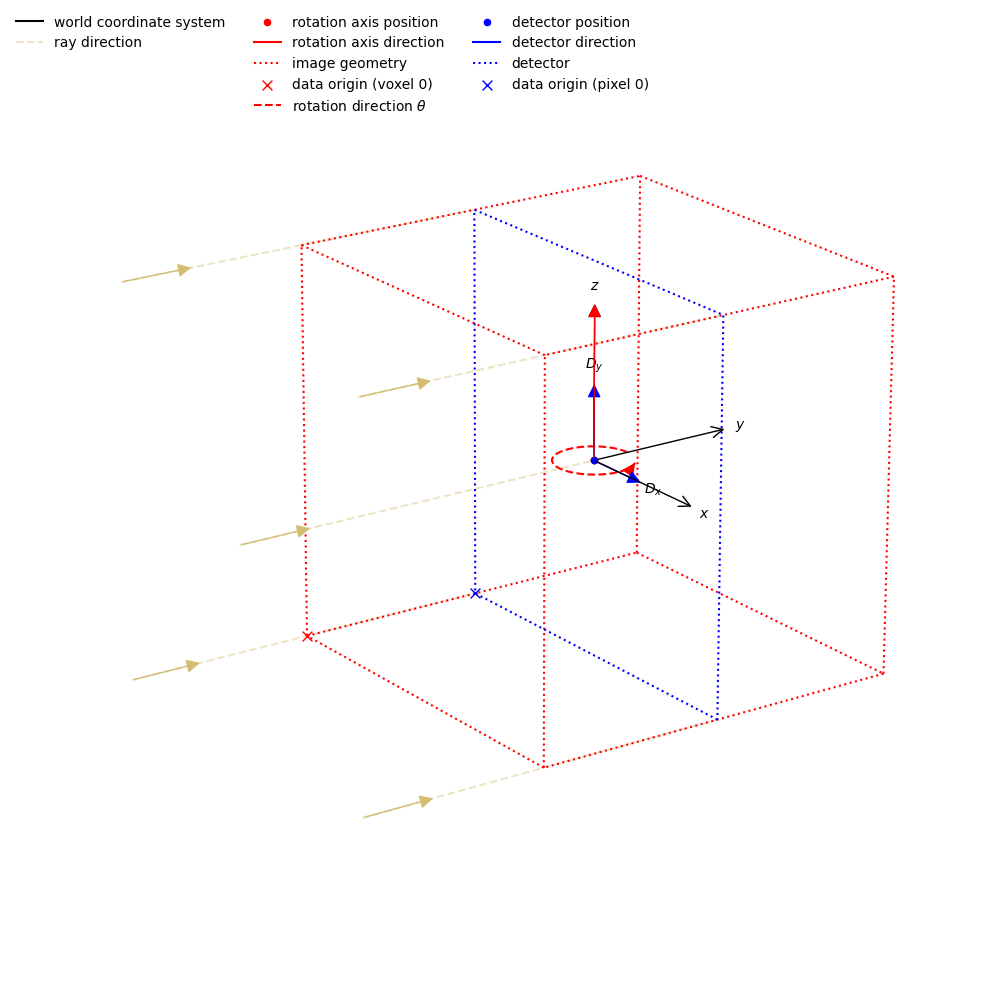

In [5]:
beam_direction = np.array([0, 1, 0])
detector_direction_x = np.array([1, 0, 0])
detector_direction_y = np.array([0, 0, 1])
rotation_axis = np.array([0, 0, 1])

ag = AcquisitionGeometry.create_Parallel3D(ray_direction = beam_direction,
                                      detector_direction_x = detector_direction_x,
                                      detector_direction_y = detector_direction_y,
                                      rotation_axis_direction = rotation_axis)              
ag.set_angles(angle_set)
ag.set_panel((pixels_x, pixels_y))

show_geometry(ag)

data = AcquisitionData(xray_image_set, geometry=ag)
data.reorder('astra')

We need to apply the Beer-Lambert law so the intensity values correspond to absorption caused by the material.

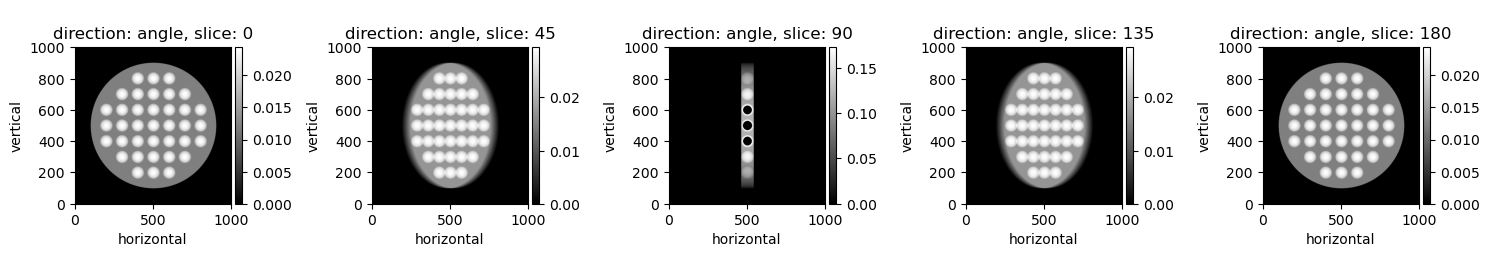

In [6]:
data = TransmissionAbsorptionConverter(white_level=1.0)(data)
show2D(data, slice_list=[('angle', 0), ('angle', 45), ('angle',90), ('angle', 135), ('angle',180)], num_cols=5)

Use a realistic spectra
Include lots of noise
Show an example without saturation on the long edge but show low intensity on the short edge (needs noise)
Show histogram
Limited angle example

Fix range

Notice that the projections have quite different levels of intensity at different projections as we look through the long and short plane of the flat sample.

Let's see what it looks like if we try to reconstruct the grid from these projections. We use the filtered back projection (FBP) algorithm and view slices through the reconstructed volume.

In [ ]:
# Reconstruct using FBP
recon = FBP(image_geometry=None, acquisition_geometry=ag)(data)

# Plot the results
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[2]/2)), ('horizontal_x',int(recon.shape[1]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)

We notice some strange artefacts in the reconstruction. This is because of the anisotropic absorption we noticed in the projections. In practice, it's often not even possible to scan the sample along the long edge, so tomography scans are limited in angle and similar artefacts are seen. A common solution to these kind of artefacts is to tilt the sample and rotation axis to give a more uniform absorption profile, this setup is called laminography. We can simulate the laminography setup by projecting the original grid volume with a tilted rotation axis We choose a tilt angle as small as possible, here 15 degrees, to equalise the attenuation per projection

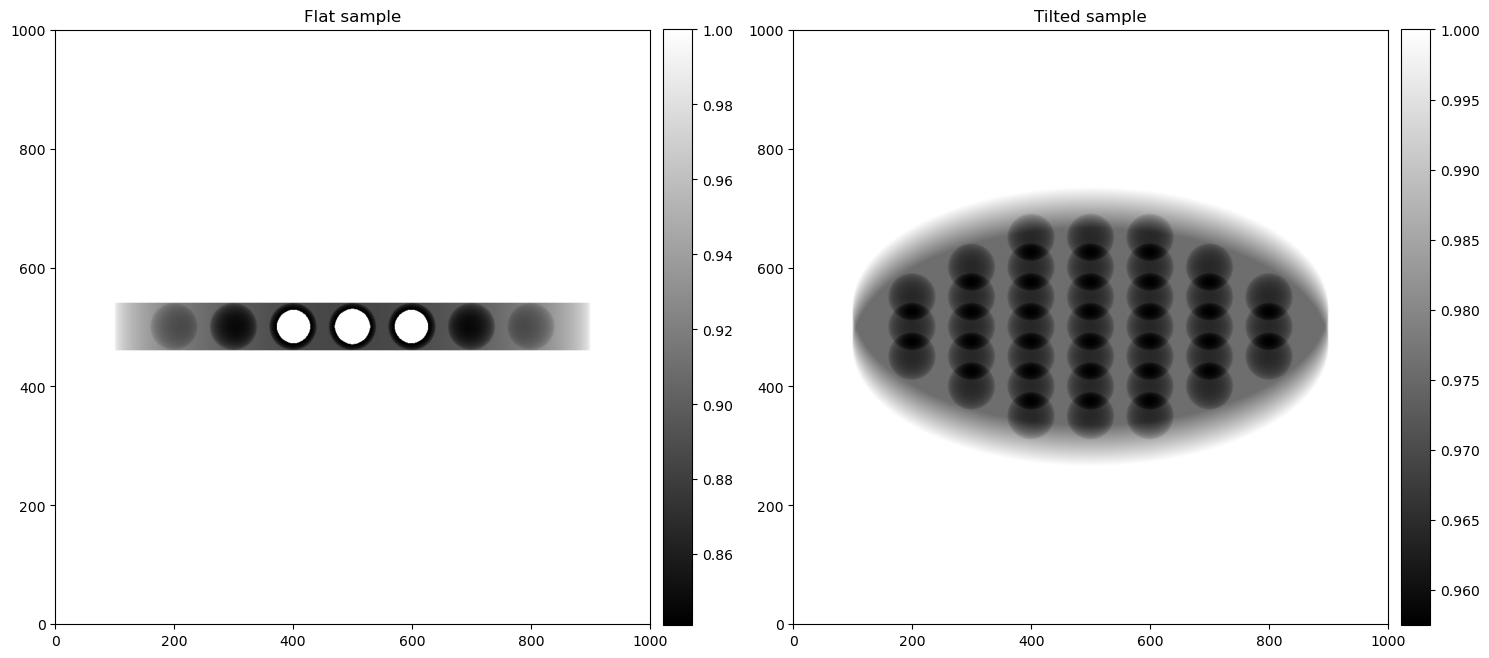

In [4]:
# Create the simulation
simulation_name = "cylinder"
create_cylinder_with_spheres(simulation_name=simulation_name, cylinder_radius=200, plane='xy')
# Compute an X-ray image
gvxr.displayScene()
xray_image1 = np.array(gvxr.computeXRayImage(), dtype=np.single)/ gvxr.getTotalEnergyWithDetectorResponse()

# tilt the sample
tilt = 30 # degrees
tilt_axis = np.array([0, 1, 0]) # around the detector x direction

gvxr.rotateNode(simulation_name, tilt, *tilt_axis)
xray_image2 = np.array(gvxr.computeXRayImage(), dtype=np.single)/ gvxr.getTotalEnergyWithDetectorResponse()
show2D([xray_image1, xray_image2], ['Flat sample', 'Tilted sample'])

Simulate the full CT scan

In [5]:
# specify number of projections
start = 0
stop = 360
step = 1
angle_set = np.arange(start, stop, step)
xray_image_set = np.zeros((stop, pixels_x, pixels_y), dtype=np.float32)

# specify the rotation axis, around z
rotation_axis = np.array([0, 0, 1])
for N in angle_set:
    # Rotate
    gvxr.rotateNode(simulation_name, N, *rotation_axis)
    # Compute xray image
    xray_image = np.array(gvxr.computeXRayImage(), dtype=np.single)/ gvxr.getTotalEnergyWithDetectorResponse()
    xray_image_set[N] = xray_image
    # Rotate back to origin
    gvxr.rotateNode(simulation_name, -N, *rotation_axis)

# use the islicer tool to scroll through the projections
islicer(xray_image_set)

Setup the geometry for the tilted laminography setup

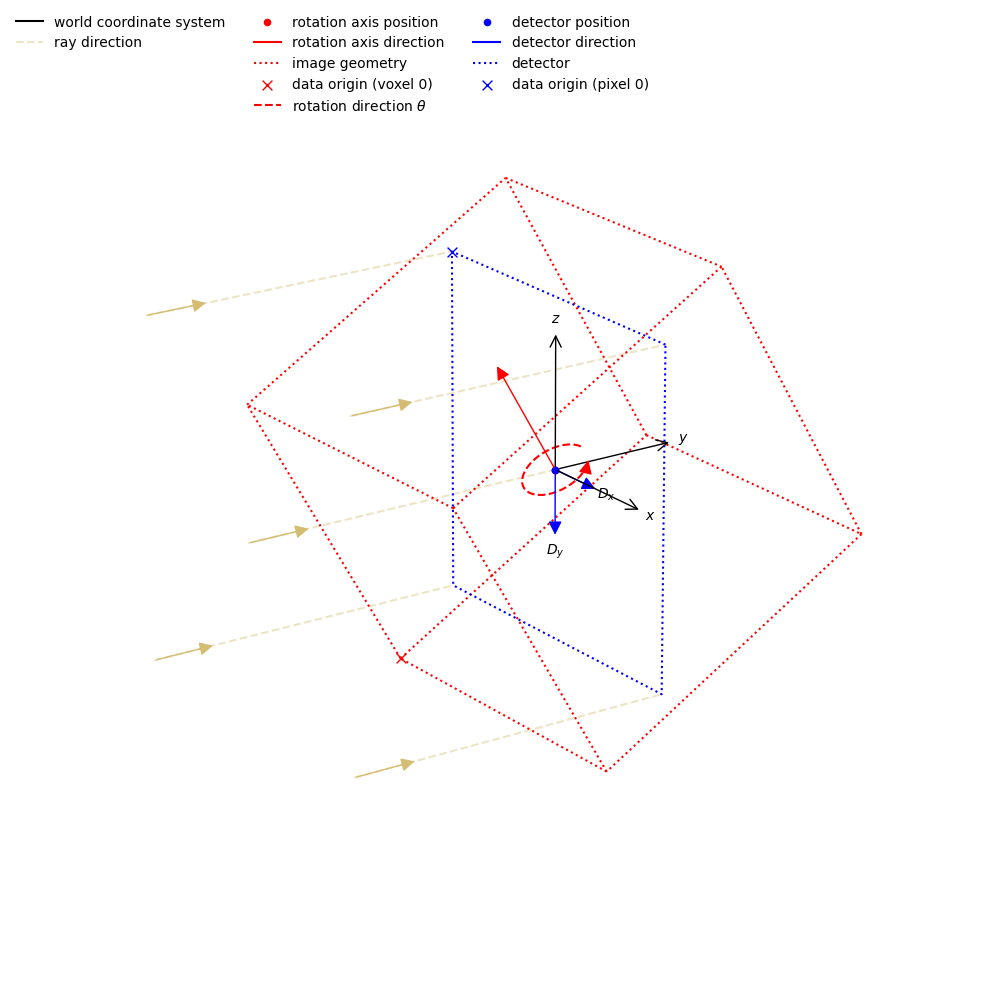

In [ ]:
beam_direction = np.array([0, 1, 0])
detector_x_direction = np.array([1, 0, 0])
detector_y_direction = np.array([0, 0, -1])
rotation_axis = np.array([0, 0, 1]) # the untilted rotation axis

# create the tilted rotation axis
tilt_rad = np.deg2rad(tilt)
rotation_matrix = Rotation.from_rotvec(tilt_rad * detector_x_direction)
tilted_rotation_axis = rotation_matrix.apply(rotation_axis)

ag = AcquisitionGeometry.create_Parallel3D(ray_direction = beam_direction,
                                      detector_direction_x = np.array([1, 0, 0]),
                                      detector_direction_y = np.array([0, 0, -1]),
                                      rotation_axis_direction = list(tilted_rotation_axis))                   
ag.set_angles(angle_set)
ag.set_panel((pixels_x, pixels_y),
             list([diad_model.effective_pixel_spacing_in_um[0]/1000, diad_model.effective_pixel_spacing_in_um[0]/1000]))

show_geometry(ag)

data = AcquisitionData(xray_image_set, geometry=ag)
data.reorder('astra')

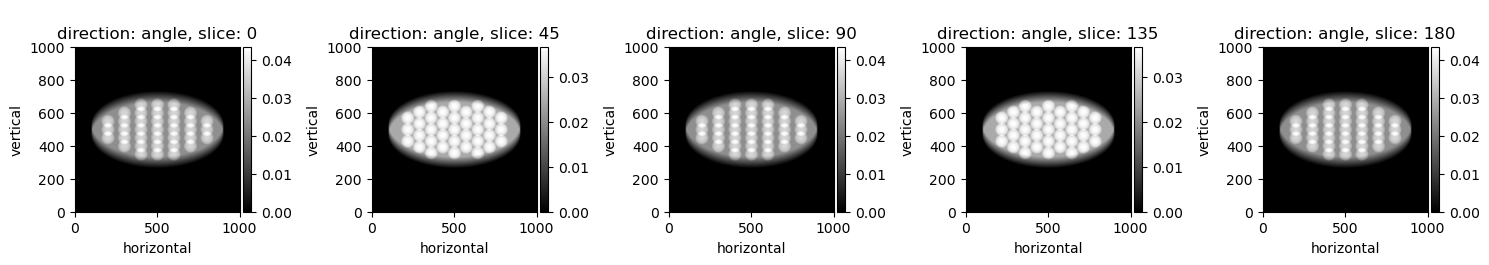

In [7]:
# apply Beer-Lambert law
data = TransmissionAbsorptionConverter(white_level=1.0)(data)
show2D(data, slice_list=[('angle', 0), ('angle', 45), ('angle',90), ('angle', 135), ('angle',180)], num_cols=5)

The projections now have very uniform attenuation. Let's try reconstructing this dataset

In [ ]:
# Reconstruct using FBP
recon = FBP(image_geometry=None, acquisition_geometry=ag)(data)

# Plot the results
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[2]/2)), ('horizontal_x',int(recon.shape[1]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)

In [27]:
from cil.processors import Binner
data_binned = Binner(roi={'horizontal': (None, None, 2), 'vertical': (None, None, 2)})(data)

There are also artefacts in this reconstruction which are due to the way the laminography setup causes an uneven distribution of projections. When considering using the laminography setup, we need to balance the impact of the different kinds of artefacts. In general we should use the smallest tilt angle possible to reduce the projection anisotropy.

In [31]:
ag = data_binned.geometry
ig = ag.get_ImageGeometry()
A = ProjectionOperator(ig, ag)

# Recontruct with FISTA least squares with non-negativity constraint
LS = LeastSquares(A=A, b=data_binned)

alpha = 0.005
TV = FGP_TV(alpha=alpha, nonnegativity=True, device='gpu')

fista_TV = FISTA(initial=ig.allocate(0), f=LS, g=TV, update_objective_interval=10)
fista_TV.run(30)
TV_reco = fista_TV.solution

  0%|          | 0/30 [00:00<?, ?it/s]

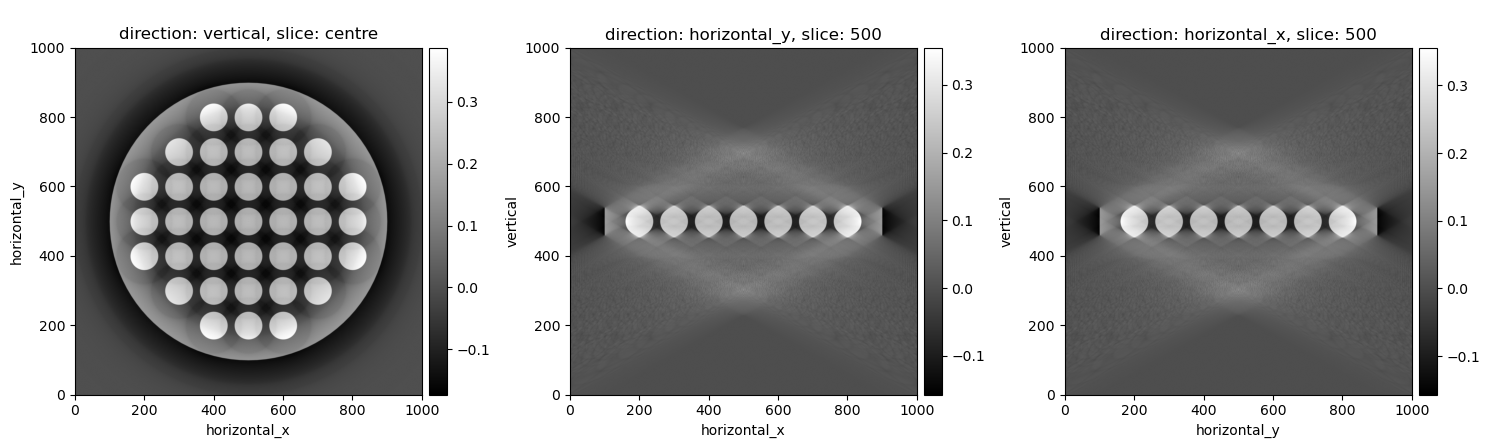

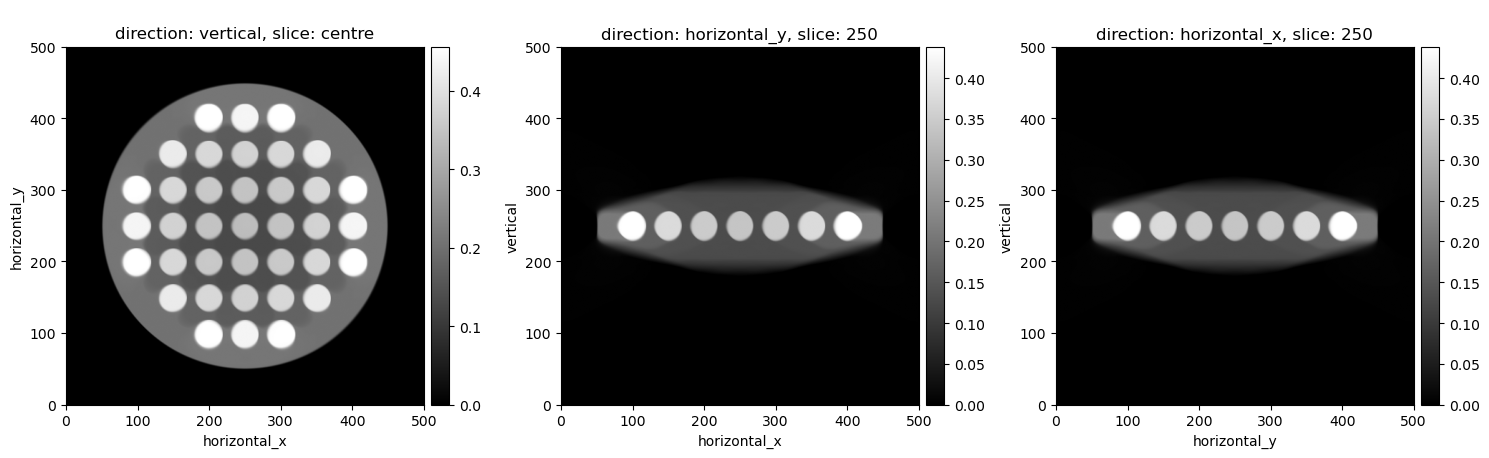

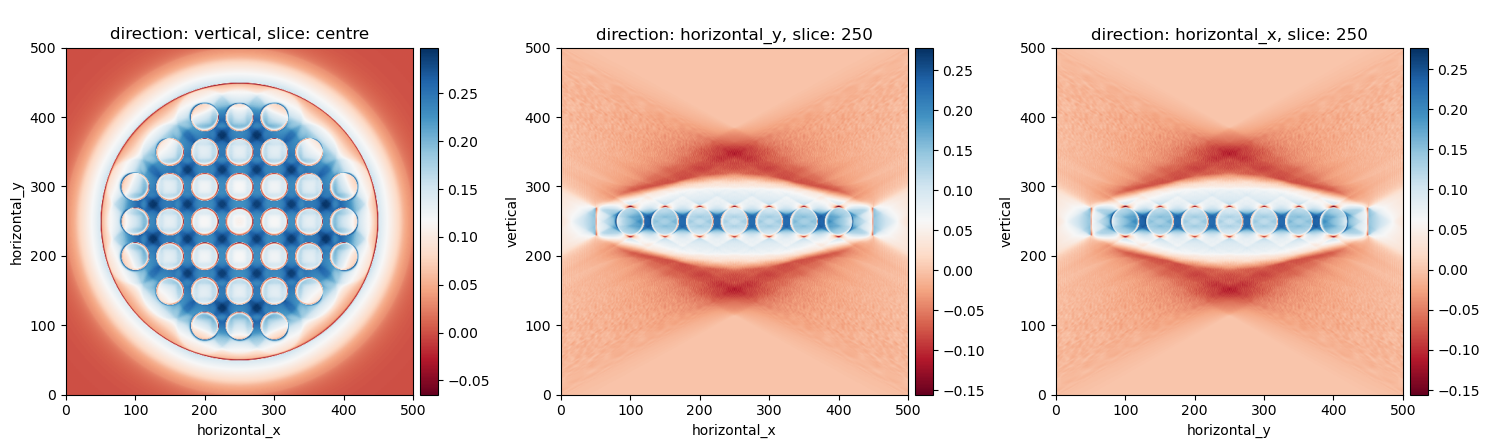

In [37]:
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[2]/2)), ('horizontal_x',int(recon.shape[1]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)
slice_list = [('vertical','centre'), ('horizontal_y',int(TV_reco.shape[2]/2)), ('horizontal_x',int(TV_reco.shape[1]/2))]
show2D(TV_reco,
       slice_list=slice_list,
       num_cols=3)
recon_binned = Binner(roi={'horizontal_x': (None, None, 2), 'horizontal_y': (None, None, 2), 'vertical': (None, None, 2)})(recon)
show2D(TV_reco-recon_binned,
       slice_list=slice_list,
       num_cols=3,
       cmap="RdBu")

Another common scenario with laminography samples, is that only a small region of interest (ROI) within the sample is fully scanned and parts of the sample outside the ROI will come in and out of view depending on the projection. We can simulate this scenario by generating a larger cylinder

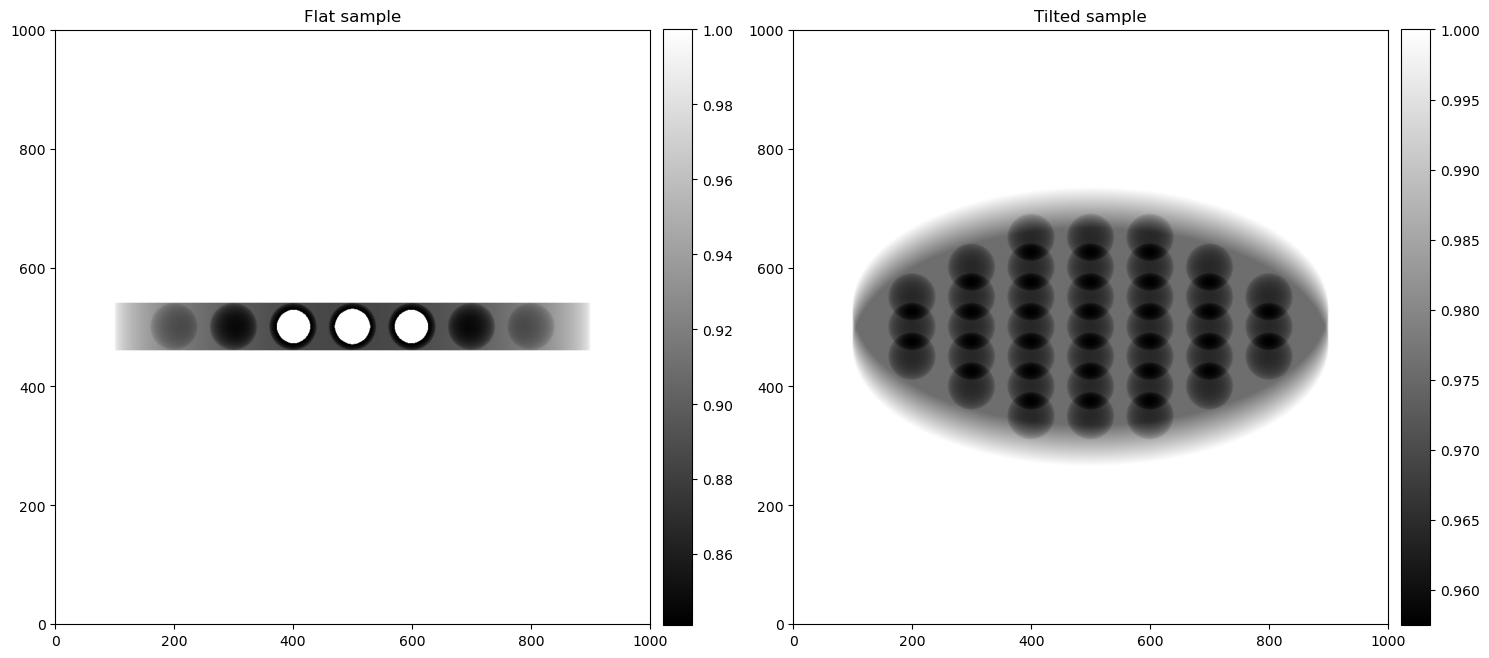

In [38]:
# Create the simulation
simulation_name = "cylinder"
create_cylinder_with_spheres(simulation_name=simulation_name, cylinder_radius=200, plane='xy')
# Compute an X-ray image
gvxr.displayScene()
xray_image1 = np.array(gvxr.computeXRayImage(), dtype=np.single)/ gvxr.getTotalEnergyWithDetectorResponse()

# tilt the sample
tilt = 30 # degrees
tilt_axis = np.array([0, 1, 0]) # around the detector x direction

gvxr.rotateNode(simulation_name, tilt, *tilt_axis)
xray_image2 = np.array(gvxr.computeXRayImage(), dtype=np.single)/ gvxr.getTotalEnergyWithDetectorResponse()
show2D([xray_image1, xray_image2], ['Flat sample', 'Tilted sample'])

Simulate the CT scan, convert to absorption and create the geometry

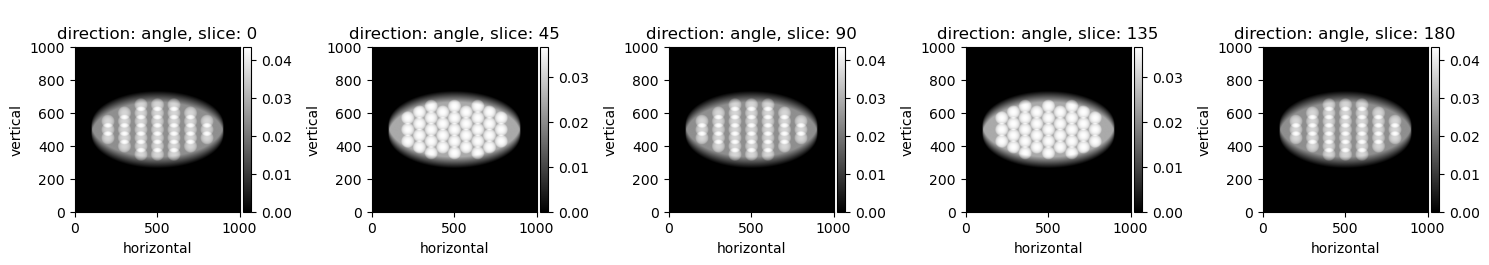

: 

In [ ]:
# specify number of projections
start = 0
stop = 360
step = 1
angle_set = np.arange(start, stop, step)
xray_image_set = np.zeros((stop, pixels_x, pixels_y), dtype=np.float32)

# specify the rotation axis, around z
rotation_axis = np.array([0, 0, 1])
for N in angle_set:
    # Rotate
    gvxr.rotateNode(simulation_name, N, *rotation_axis)
    # Compute xray image
    xray_image = np.array(gvxr.computeXRayImage(), dtype=np.single)/ gvxr.getTotalEnergyWithDetectorResponse()
    xray_image_set[N] = xray_image
    # Rotate back to origin
    gvxr.rotateNode(simulation_name, -N, *rotation_axis)

# create the geometry
beam_direction = np.array([0, 1, 0])
detector_x_direction = np.array([1, 0, 0])
detector_y_direction = np.array([0, 0, -1])
rotation_axis = np.array([0, 0, 1]) # the untilted rotation axis

tilt_rad = np.deg2rad(tilt)
rotation_matrix = Rotation.from_rotvec(tilt_rad * detector_x_direction)
tilted_rotation_axis = rotation_matrix.apply(rotation_axis)

ag = AcquisitionGeometry.create_Parallel3D(ray_direction = beam_direction,
                                      detector_direction_x = np.array([1, 0, 0]),
                                      detector_direction_y = np.array([0, 0, -1]),
                                      rotation_axis_direction = list(tilted_rotation_axis))                   
ag.set_angles(angle_set)
ag.set_panel((pixels_x, pixels_y),
             list([diad_model.effective_pixel_spacing_in_um[0]/1000, diad_model.effective_pixel_spacing_in_um[0]/1000]))

data = AcquisitionData(xray_image_set, geometry=ag,)
data.reorder('astra')
data = TransmissionAbsorptionConverter(white_level=1.0)(data)
show2D(data, slice_list=[('angle', 0), ('angle', 45), ('angle',90), ('angle', 135), ('angle',180)], num_cols=5)

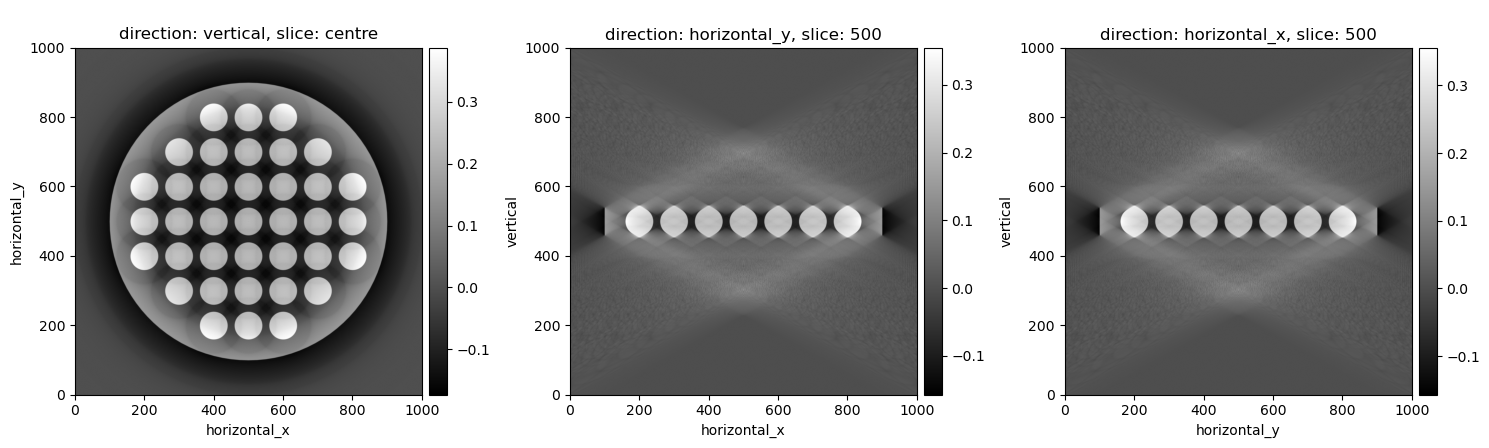

In [19]:
# Reconstruct using FBP
recon = FBP(image_geometry=None, acquisition_geometry=ag)(data)

# Plot the results
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[2]/2)), ('horizontal_x',int(recon.shape[1]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)

The reconstruction contains a bright ring, this is common with ROI data because the projections contain information from outside the ROI. To solve this we need to define an acquisition geometry which is larger than the detector to account for the information outside the ROI.

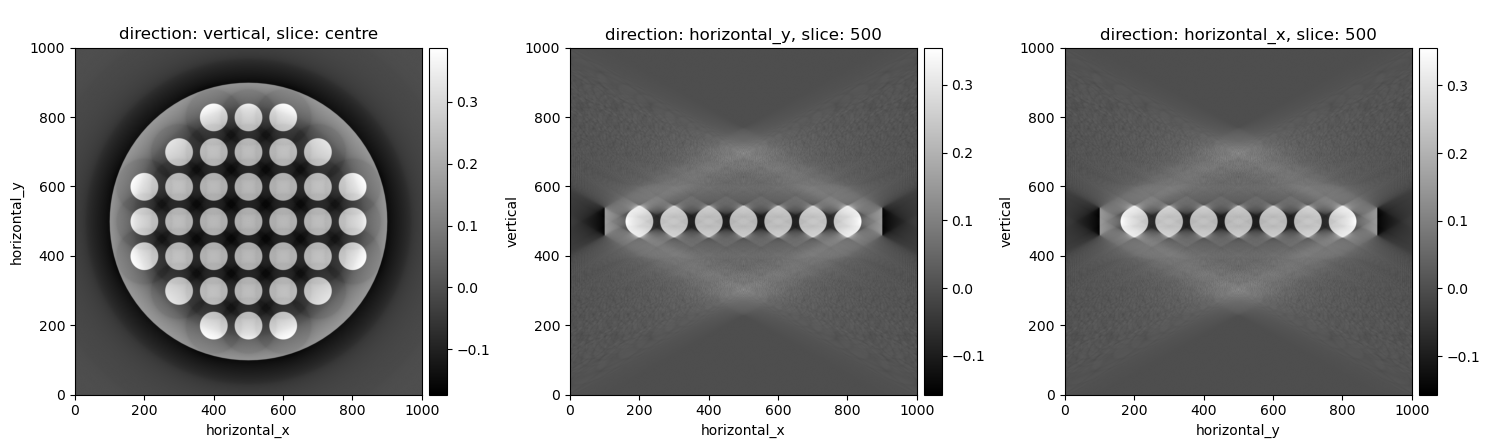

In [20]:
# Reconstruct using FBP
ig = ag.get_ImageGeometry()
padsize = 100 # approximately the size of the object outside the detector (in pixels)
data_pad = Padder.edge(pad_width={'horizontal': padsize})(data)

recon = FBP(image_geometry=ig, acquisition_geometry=data.geometry)(data_pad)

# Plot the results
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[2]/2)), ('horizontal_x',int(recon.shape[1]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
gvxr.destroy()

: 